In [2]:
# -*- coding: utf-8 -*-
""" parametric_LSTM.ipynb """

# Import the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
##############################################################################
# Parameters used:
stock = 'BTC-USD'             # Stock name
start_date = '2012-01-01'     # Start Date for data
end_date = '2021-01-11'       # End Date of Data

dlf = 0.9                     # Train Data length factor

l_input = 30                  # length of input vector
l_output = 1                  # Length of output vector

l1 = l_input                  # Number of Layer 1 Neurons
l2 = l1                       # Number of Layer 2 Neurons
hl = l1/2 #30                       # Number of hidden Layer Neurons

In [5]:
df = pd.read_excel('BTC-USD.xlsx')
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
1,2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2,2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
3,2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
4,2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100,398.821014
...,...,...,...,...,...,...,...
2299,2021-01-06,36879.699219,33514.035156,34013.613281,36824.363281,75289433811,36824.363281
2300,2021-01-07,40180.367188,36491.191406,36833.875000,39371.042969,84762141031,39371.042969
2301,2021-01-08,41946.738281,36838.636719,39381.765625,40797.609375,88107519480,40797.609375
2302,2021-01-11,38346.531250,30549.599609,38346.531250,35566.656250,123320567399,35566.656250


In [6]:
data = df.filter(['Close'])
#Scale the data to a numpy array
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values)

#Get the number of rows to train the model on
data_len = len(data)
training_len = int( data_len * dlf )
test_len = data_len - training_len - l_output 

In [7]:
x_train = []
y_train = []

for i in range(0, training_len):
    x_train.append(scaled_data[i:i+l_input, 0])
    y_train.append(scaled_data[i+l_input:i+l_input+l_output, 0])
#Convert the x_train and y_train to numpy arrays 
x_train = np.array(x_train)
y_train = np.array(y_train)
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#########################################
### Create the test data sets x_test and y_test
x_test = []
y_test = []

for i in range(training_len, training_len+test_len):
    x_test.append(scaled_data[i-l_input:i, 0])
    y_test.append(scaled_data[i:i+l_output, 0])
#Convert the data to a numpy array
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [9]:
model = Sequential()
#adding layer 1 neurons
model.add(LSTM(l1, return_sequences=True, input_shape=(x_train.shape[1], 1), dropout=0.2))
#adding layer 2 neurons
model.add(LSTM(l2, return_sequences= False, dropout=0.2))
#adding hidden layer neurons
model.add(Dense(hl))
#adding output layer neurons
model.add(Dense(l_output))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
len(x_train)

2073

In [12]:
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
33/33 [==============================] - 4s 29ms/step - loss: 0.0025
Epoch 2/10
33/33 [==============================] - 1s 29ms/step - loss: 6.1293e-04
Epoch 3/10
33/33 [==============================] - 1s 29ms/step - loss: 5.7051e-04
Epoch 4/10
33/33 [==============================] - 1s 30ms/step - loss: 5.2939e-04
Epoch 5/10
33/33 [==============================] - 1s 32ms/step - loss: 5.7623e-04
Epoch 6/10
33/33 [==============================] - 1s 30ms/step - loss: 5.5047e-04
Epoch 7/10
33/33 [==============================] - 1s 30ms/step - loss: 5.9810e-04
Epoch 8/10
33/33 [==============================] - 1s 29ms/step - loss: 5.5877e-04
Epoch 9/10
33/33 [==============================] - 1s 30ms/step - loss: 5.8610e-04
Epoch 10/10
33/33 [==============================] - 1s 30ms/step - loss: 5.9915e-04


In [13]:
predictions = model.predict(x_test)

In [14]:
predictions = scaler.inverse_transform(predictions)

In [15]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))

In [16]:
#Show the last predicted price
print(predictions[-1][0])
print('rmse=',rmse)

23724.709
rmse= 12827.350746882577


<ipython-input-17-7114c37e83c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predictions


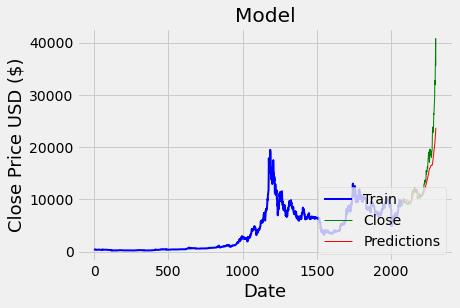

In [17]:
########################################
#Plot the data
train = data[:training_len]
Test = data[training_len:training_len+test_len]
Test['Predictions'] = predictions
#Visualize the data
# plt.figure(figsize=(14,7))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], color='b', linewidth = 2)
plt.plot(Test['Close'], color='g', linewidth = 1)
plt.plot(Test['Predictions'], color='r', linewidth = 1)
plt.legend(['Train', 'Close', 'Predictions'], loc='lower right')
plt.show()

In [18]:
model.save('m1.h5')